In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy import stats
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install xlsxwriter
pd.options.mode.chained_assignment = None  # default='warn'
import statsmodels.api as sm
from statsmodels.formula.api import ols
## https://www.kaggle.com/code/alexmaszanski/two-way-anova-with-python/notebook
from scipy.stats import linregress
import glob
import researchpy as rp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re

**There are four assumptions that must be met before using two-way ANOVA:**

- Normality: Observations from the sample population are normally distributed.
- Sample Size: The number of observations must be the same for each group.
- Equal Variances: The variances for each group are equal.
- Independence: Observations in each group are independent.

In [5]:
currdir= os.getcwd()
parent = os.path.dirname(currdir)
gparent=os.path.dirname(parent)
lines_to_skip = 10 # adjust this as necessary

# count the number of header lines
header_lines = 3 # adjust this as necessary

plate_type = 'DIV19'
# read the csv file into a pandas DataFrame, skipping the metadata at the top
# df = pd.read_csv(filename, skiprows=lines_to_skip, header=[i for i in range(header_lines)])
### read all data

firstTableHeading = "Number of Spikes"
## conditions taken: ### we will define this as dose1,dose2, dose3, dose4, each incrementing in terms of doses
basal_folder = f"{parent}/data/DIV19_plate1,3_CNO/Div19_basal_CNO"
dose1_folder = f"{parent}/data/DIV19_plate1,3_CNO/Div19_5uM_CNO"
dose2_folder = f"{parent}/data/DIV19_plate1,3_CNO/Div19_10uM_CNO"
dose3_folder =f"{parent}/data/DIV19_plate1,3_CNO/Div19_15uM_CNO"
dose4_folder = f"{parent}/data/DIV19_plate1,3_CNO/Div19_20uM_CNO"
# basal_df= pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 basal(000)(000)_CompiledData(1).csv",
#                     skiprows = lines_to_skip)

# bicucilin_df = pd.read_csv(f"data/Div19_2way/Div19 H11 5th batch of gRNAs plate2 bicu 6 microM(000)(000)_CompiledData.csv",
#                          skiprows = lines_to_skip)

# basal_df = basal_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# bicucilin_df = bicucilin_df.drop(columns=['Unnamed: 9']) # , 'Unnamed: 0'
# basal_df

In [8]:
def read_csvs_to_dict(folder):
    files = glob.glob(os.path.join(folder, "*.csv"))
    print(files)
    data_dict = {}
    for file in files:
        # Extracting the plate number from the filename
        plate_num = re.search(r'plate\s?(\d+)', file, re.IGNORECASE)
        if plate_num:
            print(plate_num)
            plate_key = f"plate_{plate_num.group(1)}"
            df = pd.read_csv(file, skiprows = lines_to_skip)
            df = df.drop(columns=['Unnamed: 9'])
            data_dict[plate_key] = df
    return data_dict
basal_files_dict = read_csvs_to_dict(basal_folder)
# dose1_files_dict = read_csvs_to_dict(dose1_folder)
# dose2_files_dict = read_csvs_to_dict(dose2_folder)
# dose3_files_dict = read_csvs_to_dict(dose3_folder)
# dose4_files_dict = read_csvs_to_dict(dose4_folder)

basal_files_dict.keys()


['/home/poojaparameswaran/Documents/SoderlingLab/MEA_analysis/data/DIV19_plate1,3_CNO/Div19_basal_CNO/DIV 19 LSL-Cas9-PVcre with fith batch of gRNAs plate3 basal(000)(000)_NeuralEventDetector_LFPneuralMetrics_CompiledData.csv', '/home/poojaparameswaran/Documents/SoderlingLab/MEA_analysis/data/DIV19_plate1,3_CNO/Div19_basal_CNO/DIV 19 LSL-Cas9-PVcre with fith batch of gRNAs plate1 basal(000)(000)_NeuralEventDetector_LFPneuralMetrics_CompiledData.csv']
<re.Match object; span=(71, 77), match='plate1'>
<re.Match object; span=(71, 77), match='plate1'>
[]
['/home/poojaparameswaran/Documents/SoderlingLab/MEA_analysis/data/DIV19_plate1,3_CNO/Div19_10uM_CNO/DIV 19 LSL-Cas9-PVcre with fith batch of gRNAs plate3  10uM CNO(000)(000)_NeuralEventDetector_LFPneuralMetrics_CompiledData.csv', '/home/poojaparameswaran/Documents/SoderlingLab/MEA_analysis/data/DIV19_plate1,3_CNO/Div19_10uM_CNO/DIV 19 LSL-Cas9-PVcre with fith batch of gRNAs plate1  10uM CNO(000)(000)_NeuralEventDetector_LFPneuralMetrics_Co

dict_keys(['plate_1'])

In [37]:
def concat_plates(dfs_dict, firstHeading):
    experiment = {}
    testparams_concat = {}
    for plate, df in dfs_dict.items():
        maxrows = df.shape[0]
        vals_between_tables = 16
        titles = [heading_ind for heading_ind in range(14, maxrows+16, 16)]
        titles.insert(0,0)
        # # Empty dictionary to store dataframes
        # Loop through start indices
        for ind in range(len(titles) -1):
            if ind == 0:
                ## Handle mean firing rate
                key = firstHeading
                table = df.iloc[titles[ind] : titles[ind +1], :]
                # table = rename_row_names(table)
            elif ind != 0:
                table = df.iloc[titles[ind] : titles[ind +1], :]
                key = table.iloc[0][0] # just get name
                table = df.iloc[titles[ind] +2: titles[ind +1], :]

            table.set_index('Unnamed: 0', inplace=True)
            if key not in experiment:
                experiment[key] = []
            experiment[key].append(table)
    
    for testparam, df_list in experiment.items():
        concated_table = pd.concat(df_list, ignore_index=False)
        testparams_concat[testparam] = concated_table
        
    return testparams_concat

basal_dict_wmeanSEM= concat_plates(basal_files_dict, firstTableHeading)
bicu2uM_dict_wmeanSEM = concat_plates(bicu2uM_files_dict, firstTableHeading)
bicu6uM_dict_wmeanSEM = concat_plates(bicu6uM_files_dict, firstTableHeading)
bicu26uM_dict_wmeanSEM = concat_plates(bicu26uM_files_dict, firstTableHeading)


In [38]:
def remove_mean_SEM(dictionary, chemical_type):
    for key, value in dictionary.items():
        to_drop = [index for index in ['B Mean', 'B SEM'] if index in value.index]
        if to_drop:
            dictionary[key] = value.drop(index=to_drop)
        dictionary[key]['Chemical_Type']=chemical_type
    return dictionary

basal_dictmessy = remove_mean_SEM(basal_dict_wmeanSEM, chemical_type="basal")
bicu2uM_dictmessy = remove_mean_SEM(bicu2uM_dict_wmeanSEM,chemical_type="bicucilin2uM")
bicu6uM_dictmessy = remove_mean_SEM(bicu6uM_dict_wmeanSEM, chemical_type="bicucilin6uM")
bicu26uM_dictmessy = remove_mean_SEM(bicu26uM_dict_wmeanSEM, chemical_type="bicucilin26uM")
# print(basal_dict['Number of Covered Electrodes'].columns)
basal_dictmessy['Mean Firing Rate (Hz)']


,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Unnamed: 0,,,,,,,,,
B Replicates,1.827421,3.278172,5.325334,3.735184,0.840568,3.100167,3.665484,2.135017,basal
NaN,0.901503,6.809265,0.281511,1.074499,4.000626,3.151920,3.726210,1.878548,basal
NaN,7.349958,2.711603,1.391903,2.271077,2.575334,2.032137,7.272120,2.567195,basal
NaN,1.503130,2.224958,1.152129,4.904215,0.460559,1.641068,5.093907,7.638564,basal
NaN,2.211811,3.282137,1.718907,4.165275,3.251043,0.664441,4.756469,1.001461,basal
NaN,0.859349,1.075960,0.144616,2.927588,2.784850,0.998122,7.111853,2.213063,basal
NaN,1.724332,4.111853,1.263982,3.683848,1.036519,1.958890,7.449290,4.388356,basal
NaN,4.589942,5.143573,2.862270,9.942821,0.817613,3.272538,4.589733,2.458890,basal
NaN,1.027337,1.117696,1.815109,3.771077,1.239149,1.111227,5.449917,1.208890,basal


In [39]:
def rename_row_names(experiment_df):
    # 'Unnamed: 0' is a column
    experiment_df = experiment_df.reset_index()
    experiment_df = experiment_df.drop(columns="Unnamed: 0", errors="ignore")
    experiment_df.index = ["Replicate{}".format(i+1) for i in range(len(experiment_df))]
    return experiment_df

basal_dict = {key: rename_row_names(df) for key, df in basal_dictmessy.items()}
bicu2uM_dict = {key: rename_row_names(df) for key, df in bicu2uM_dictmessy.items()}
bicu6uM_dict = {key: rename_row_names(df) for key, df in bicu6uM_dictmessy.items()}
bicu26uM_dict = {key: rename_row_names(df) for key, df in bicu26uM_dictmessy.items()}

bicu26uM_dict['Area Under Normalized Cross-Correlation']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,0.778279,0.812687,0.930865,0.900980,0.943671,0.839765,0.814649,0.939628,bicucilin26uM
Replicate2,0.787473,0.763014,0.790683,0.964228,0.918714,0.979612,0.780660,0.974643,bicucilin26uM
Replicate3,0.898023,0.850264,0.839009,0.558155,0.944173,0.763763,0.814237,0.798451,bicucilin26uM
Replicate4,0.873598,0.895500,0.891505,0.940932,0.830616,0.908209,0.913402,0.976451,bicucilin26uM
Replicate5,0.936168,0.781735,0.950835,0.929467,0.877654,0.778103,0.864511,0.995143,bicucilin26uM
Replicate6,0.917964,0.734640,0.766233,0.878518,0.981199,0.914851,0.862615,0.889977,bicucilin26uM
Replicate7,0.956405,0.950759,0.922910,0.942138,0.897919,0.937627,0.934439,0.972222,bicucilin26uM
Replicate8,0.917180,0.909795,0.926899,0.948554,0.961456,0.969048,0.978562,0.857867,bicucilin26uM
Replicate9,0.859871,0.842517,0.713757,0.917768,0.846343,0.917498,0.972116,0.935806,bicucilin26uM
Replicate10,0.969465,0.811769,0.888796,0.932498,0.976411,0.985226,0.970226,0.927184,bicucilin26uM


In [40]:
all_dicts = dict(zip(["basal", "bicucilin2uM", "bicucilin6uM", "bicucilin26uM"],[basal_dict, bicu2uM_dict, bicu6uM_dict, bicu26uM_dict]))
all_dicts['basal']['Mean Firing Rate (Hz)']

,GPR37L 1,GPR37L 2,LGI2 A12,SLITRK5,THSD7 1,THSD7 2,unt1,unt2,Chemical_Type
Replicate1,1.827421,3.278172,5.325334,3.735184,0.840568,3.100167,3.665484,2.135017,basal
Replicate2,0.901503,6.809265,0.281511,1.074499,4.000626,3.151920,3.726210,1.878548,basal
Replicate3,7.349958,2.711603,1.391903,2.271077,2.575334,2.032137,7.272120,2.567195,basal
Replicate4,1.503130,2.224958,1.152129,4.904215,0.460559,1.641068,5.093907,7.638564,basal
Replicate5,2.211811,3.282137,1.718907,4.165275,3.251043,0.664441,4.756469,1.001461,basal
Replicate6,0.859349,1.075960,0.144616,2.927588,2.784850,0.998122,7.111853,2.213063,basal
Replicate7,1.724332,4.111853,1.263982,3.683848,1.036519,1.958890,7.449290,4.388356,basal
Replicate8,4.589942,5.143573,2.862270,9.942821,0.817613,3.272538,4.589733,2.458890,basal
Replicate9,1.027337,1.117696,1.815109,3.771077,1.239149,1.111227,5.449917,1.208890,basal
Replicate10,1.507930,0.885434,3.836603,3.796953,0.921953,0.662771,10.533389,1.662771,basal


In [41]:
def combine_chem_types(dict_of_alldicts):
    all_concat = {key: None for key in dict_of_alldicts['basal']}
    for type in dict_of_alldicts.keys():
        for test_parameter, df in dict_of_alldicts[type].items():
            all_concat[test_parameter]=pd.concat([all_concat[test_parameter], df], ignore_index=False)
    for testparam, df in all_concat.items():
        df.columns = df.columns.str.replace(' ', '_')
        for gene in df.columns:
            if gene != "Chemical_Type":
                df[gene]= df[gene].astype(float)
    return all_concat

TestParams_dict = combine_chem_types(all_dicts)
TestParams_dict['Network Burst Duration - Avg (sec)']

,GPR37L_1,GPR37L_2,LGI2_A12,SLITRK5,THSD7_1,THSD7_2,unt1,unt2,Chemical_Type
Replicate1,0.579647,0.859407,0.230038,0.678855,0.830284,0.654184,0.481274,0.931357,basal
Replicate2,0.601540,0.249991,0.379989,0.698682,0.807410,0.231761,0.773275,0.632968,basal
Replicate3,0.218853,0.303412,1.297274,0.602706,0.251728,0.340530,0.650301,0.695178,basal
Replicate4,0.188526,0.496046,0.262803,0.709955,0.424274,0.354893,1.039538,0.654893,basal
Replicate5,0.228881,0.522489,0.430885,0.789491,0.286888,0.347982,0.803297,0.409023,basal
...,...,...,...,...,...,...,...,...,...
Replicate32,0.455670,0.475602,0.554639,0.356517,1.047354,0.998121,0.501324,0.733050,bicucilin26uM
Replicate33,0.428454,0.769746,0.556568,0.533986,0.517722,0.618200,0.401650,0.578492,bicucilin26uM
Replicate34,0.522917,0.446758,0.599170,0.424805,0.387209,0.561704,0.502975,0.635415,bicucilin26uM
Replicate35,0.499745,0.522296,0.388505,0.525357,0.864262,0.862033,0.525369,0.578219,bicucilin26uM


In [42]:
def melt_df_Long(df):
    new_df = pd.melt(df, id_vars=['Chemical_Type'], var_name='Gene', value_name='Value')
    return new_df

for test_param, table in TestParams_dict.items():
    TestParams_dict[test_param] = melt_df_Long(table)

In [43]:
TestParams_dict['Network Burst Duration - Avg (sec)']

,Chemical_Type,Gene,Value
0,basal,GPR37L_1,0.579647
1,basal,GPR37L_1,0.601540
2,basal,GPR37L_1,0.218853
3,basal,GPR37L_1,0.188526
4,basal,GPR37L_1,0.228881
...,...,...,...
1147,bicucilin26uM,unt2,0.733050
1148,bicucilin26uM,unt2,0.578492
1149,bicucilin26uM,unt2,0.635415
1150,bicucilin26uM,unt2,0.578219


In [44]:
def categorize_gene_vs_control(testparam_df, control_var='unt2'):
    genes = list(testparam_df['Gene'].unique())
    mutants = [gene for gene in genes if "unt" not in gene]
    mutVcont_dict= {mut: pd.DataFrame for mut in mutants}
    for mutant in mutants:
        tiny_df = testparam_df[(testparam_df['Gene'] == control_var) |\
                   (testparam_df['Gene'] == mutant)]
        mutVcont_dict[mutant] = tiny_df
    return mutVcont_dict

TestParamsSectioned_dict = TestParams_dict.copy()

for test_param, table in TestParams_dict.items():
    TestParamsSectioned_dict[test_param] = categorize_gene_vs_control(table, control_var='unt2')

# print((TestParamsSectioned_dict['Number of Active Electrodes']))

In [67]:
### You want to troubleshoot w PRISM??

TESTPARAM = 'Area Under Normalized Cross-Correlation'
GENEINT = 'GPR37L_1'
TestParamsSectioned_dict[TESTPARAM][GENEINT].to_csv(f"{parent}/data/PRISM_inputs/{TESTPARAM}_{GENEINT}.csv")

In [68]:
TestParamsSectioned_dict[TESTPARAM][GENEINT]

,Chemical_Type,Gene,Value
0,basal,GPR37L_1,0.809806
1,basal,GPR37L_1,0.890126
2,basal,GPR37L_1,0.682422
3,basal,GPR37L_1,0.699101
4,basal,GPR37L_1,0.784501
...,...,...,...
1147,bicucilin26uM,unt2,0.781285
1148,bicucilin26uM,unt2,0.817439
1149,bicucilin26uM,unt2,0.641429
1150,bicucilin26uM,unt2,0.769045


In [69]:
def ensure_dirs_exists(path):
    directory = os.path.dirname(path)  # Get the directory part of the file path
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

In [72]:
from statsmodels.stats.anova import AnovaRM
def calculate_ANOVA(testparameter, df, mutant_gene, anovaRM=True,
                    show_barlabels = False, control_var="unt2"):
    """_summary_
    In a two-way repeated anova measurement test, 1 factor== within-subject, each 
        subject is exposed to all levels of this factor (chemical_Type).
        -Value is dependent variable
        -Gene is index, each gene is eitehr control or mutation so it is key identifier
        -Chemical_type is change within each subject
    
    Args:
        testparameter (_type_): _description_
        df (_type_): _description_
        mutant_gene (_type_): _description_
        anovaRM (bool): ANOVA repeated measures test?
        show_barlabels (bool, optional): _description_. Defaults to False.
        control_var (str, optional): _description_. Defaults to "unt2".

    Returns:
        Anova TABLE: showing mut (1) vs control (1), significance of gene
                        perturbation, gene&chemical
                        
            sum_sq: measure of total variation within data. how much data points differ from the mean
            df (deg of freedom): independ. values, values that are free to vary once we know
                            constraints (sample means)
            F-statistic:  model variance / residual variance. amount of variance due to the variable.
            P-value: is the variance noted (sum_sq, F-statistic) significant?
    """
    if anovaRM:
        # print(df.shape, df.head())
        df = df.groupby(['Gene', 'Chemical_Type']).mean().reset_index()
        anova_table = AnovaRM(df, depvar='Value', subject='Gene', within=['Chemical_Type']).fit()
        print(anova_table)
    else:
        model = ols('Value ~ C(Gene) + C(Chemical_Type) + C(Gene):C(Chemical_Type)', data= df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_table = anova_table.drop('Residual')
        # anova_table = anova_table.rename(index={'C(Gene)': f'C({mutant_gene})'})
    return anova_table

ANOVA_dict = {test_param: {} for test_param, dictionary in TestParamsSectioned_dict.items()}
for test_param, mutVcontrol_dict in TestParamsSectioned_dict.items():
    if test_param == TESTPARAM:
        for mut, table in mutVcontrol_dict.items():
            if mut == GENEINT:
                if table['Chemical_Type'].nunique() > 1:
                    ANOVA_dict[test_param][mut]= calculate_ANOVA(test_param, table, mut, anovaRM=False)

# ANOVA_dict['Mean Firing Rate (Hz)']['GPR37L_1']

In [73]:
ANOVA_dict[TESTPARAM][GENEINT]

,sum_sq,df,F,PR(>F)
C(Gene),0.270048,1.0,22.324451,0.000004
C(Chemical_Type),0.063181,3.0,1.741018,0.158799
C(Gene):C(Chemical_Type),0.007945,3.0,0.218935,0.883221


In [686]:
def create_multind_df(ANOVA_dict):
    pd.set_option('display.float_format', lambda x: '%.1e' % x)
    test_params = list(ANOVA_dict.keys())
    mutant_genes = list(ANOVA_dict[test_params[0]].keys())
    anova_variables = list(ANOVA_dict[test_params[0]][mutant_genes[0]].index)
    
    col_iterables = [mutant_genes, ["F-statistic", "P-value"]]
    row_iterables = [test_params, anova_variables]
    
    rindex = pd.MultiIndex.from_product(row_iterables, names=["Test Parameter", "ANOVA variables"])
    cindex = pd.MultiIndex.from_product(col_iterables)
    
    df = pd.DataFrame(index=rindex, columns= cindex)
    for test_param, testparam_dict in ANOVA_dict.items():
        for mutant, anova_df in testparam_dict.items():
            for var in anova_variables:
                df.loc[(test_param, var), (mutant, 'F-statistic')] = anova_df.loc[var, 'F']
                df.loc[(test_param, var), (mutant, 'P-value')] = anova_df.loc[var, 'PR(>F)']
                # df.loc[(test_param, 'C(Gene)'), (mutant, 'F-statistic')] = (anova_df['F']['C(Gene)'])
    return df

nf= create_multind_df(ANOVA_dict)
nf.to_csv(f"twoWayANOVA_tables/{plate_type}_ANOVAresults.csv")

In [ ]:
# Sample DataFrame

# Use the 'border' property in CSS to add lines.
styles = [
    dict(selector="th", props=[("border", "1px solid black")]),
    dict(selector="td", props=[("border", "1px solid gray")]),
    dict(selector="th.col_heading",
         props=[("border-right", "2px solid black"),
                ("border-bottom", "2px solid black")]),
    dict(selector="th.row_heading",
         props=[("border-right", "2px solid black"),
                ("border-bottom", "2px solid black")]),
    # Add more selectors for specific borders as needed
]

html = nf.style.set_table_styles(styles).render()

# Save the HTML to a file
with open('styled.html', 'w') as f:
    f.write(html)


In [649]:
def add_barlabels(ax, bar_width=0.35):
        # Iterate through the patches (bars) in the Axes object
        for bar in ax.patches:
                # The bar's width and location can be accessed through the bar's attributes
                x = bar.get_x() + bar.get_width() / 2
                y = bar.get_height()
                # Format the label with the desired precision here; round(y, 2) for two decimal places
                label = f"{y:.2f}"
                
                # Place the label above the bar, centered
                ax.text(x, y, label, ha='center', va='bottom', color='pink', fontstyle='italic', fontsize=6,
                        bbox=dict(facecolor='pink', alpha=0.3, edgecolor='none', pad=0))

In [715]:
def add_slope_labels(ax, testparam_df, gene_slope_dict, bar_width=0.35):
    mutants = list(testparam_df['Gene'].unique())
    chemical_types = list(testparam_df['Chemical_Type'].unique())
    
    fig_width, fig_height = ax.figure.get_size_inches()
    numgenes_plot = range(len(mutants))
    eg_width = fig_width/ len(numgenes_plot)
    bar_width = ax.patches[0].get_width()
    space_genes = numgenes_plot + eg_width -1 - bar_width
    print(space_genes)
    
    bars = ax.patches
    y_values = [bar.get_height() for bar in bars]
    top_yval = max(y_values)
    for ind, gene in enumerate(mutants):
        ax.text(space_genes[ind], top_yval + 0.01,
                    f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
                    f"P-value = {gene_slope_dict[gene]['p']:.2e}",
                    color='green', fontweight='bold', fontsize=6,
                    ha='center', va='bottom',
                    bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))
    # # Iterate through genes and chemical types
    # for gene in genes:
    #     if gene not in gene_slope_dict:
    #         print(f"No slope data for gene: {gene}")
    #         continue

    #     # Find the bars corresponding to the current gene
    #     gene_bars = [bar for bar in ax.patches if bar.get_height() > 0 and 
    #                  plt.getp(bar, 'label').startswith(gene) and 
    #                  plt.getp(bar, 'label').endswith(chemical_types[0])]  # Assuming the first chemical type is present

    #     if not gene_bars:
    #         print(f"No bars found for gene: {gene}")
    #         continue

    #     # Calculate the center x position of the group of bars for each gene
    #     gene_center_x = np.mean([bar.get_x() + bar.get_width() / 2 for bar in gene_bars])

    #     # Check for finite x positions
    #     if np.isfinite(gene_center_x):
    #         # Add the text label for the slope
    #         ax.text(gene_center_x, y_max + y_shift,
    #                 f"Slope = {gene_slope_dict[gene]['slope']:.2f}\n"
    #                 f"P-value = {gene_slope_dict[gene]['p']:.2e}",
    #                 color='green', fontweight='bold', fontsize=14,
    #                 ha='center', va='bottom',
    #                 bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none', pad=1))
    #         print(f"Label added for gene: {gene}")
    #     else:
    #         print(f"Non-finite x position for gene: {gene}")


In [716]:
import itertools

def compute_slope(testparam_df):
    genes = list(testparam_df['Gene'].unique())
    print(genes)
    gene_data_dict = {gene: [] for gene in genes}
    gene_slope_dict = {gene: float for gene in genes}
    for gene, perturb in itertools.product(testparam_df['Gene'].unique(), testparam_df['Chemical_Type'].unique()):
        mask = testparam_df['Gene'].str.contains(gene) & testparam_df['Chemical_Type'].str.contains(perturb)
        gene_data_dict[gene] = testparam_df[mask]['Value'].tolist()
        slope, intercept, r, p, se = linregress(np.arange(len(gene_data_dict[gene])), gene_data_dict[gene])
        gene_slope_dict[gene] = {"slope":slope, "r":r, "p":p, "se":se}
    return gene_slope_dict

trial = compute_slope(TestParams_dict['Network Burst Duration - Avg (sec)'])

['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt1', 'unt2']


['GPR37L_1', 'GPR37L_2', 'LGI2_A12', 'SLITRK5', 'THSD7_1', 'THSD7_2', 'unt1', 'unt2']
GENE_SLOPE_dICT: {'GPR37L_1': {'slope': -0.00214061685971686, 'r': -0.26784629844326785, 'p': 0.11425031865500147, 'se': 0.001320529990530133}, 'GPR37L_2': {'slope': -0.001962575160875161, 'r': -0.22034749939882375, 'p': 0.19657655908330238, 'se': 0.0014899476480636565}, 'LGI2_A12': {'slope': -0.004071030630630632, 'r': -0.38709957111261345, 'p': 0.01968043428767835, 'se': 0.001662995226965221}, 'SLITRK5': {'slope': 0.0009926321750321754, 'r': 0.16434050154225693, 'p': 0.33817516443591, 'se': 0.0010217836779850714}, 'THSD7_1': {'slope': -0.00045666808236808276, 'r': -0.0592075035051485, 'p': 0.7315917348063781, 'se': 0.0013204498078108157}, 'THSD7_2': {'slope': 0.0012205866151866157, 'r': 0.153364922403405, 'p': 0.37184978750775655, 'se': 0.0013487597713011349}, 'unt1': {'slope': -0.00045876640926640895, 'r': -0.052133226426835544, 'p': 0.7626783567438038, 'se': 0.0015071156075784705}, 'unt2': {'slope

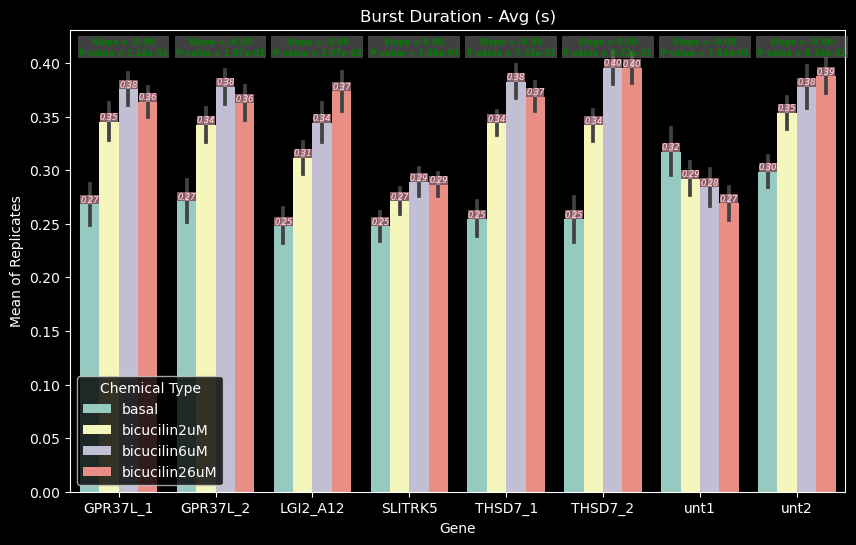

In [717]:
def create_bar_chart(testparameter, df, show_barlabels = True, control_var="unt2"):
    bar_width=0.20
    plt.figure(figsize=(10, 6)) # Adjust the size as needed
    # Create a bar plot
    ax = sns.barplot(x='Gene', y='Value', hue='Chemical_Type', data=df, errorbar='se')

    plt.title(f"{testparameter}")
    plt.xlabel('Gene')
    plt.ylabel('Mean of Replicates')
    plt.legend(title='Chemical Type')
    if show_barlabels:
        add_barlabels(ax)
    gene_slope_dict = compute_slope(df)
    print(f"GENE_SLOPE_dICT: {gene_slope_dict}")
    if show_barlabels:
        add_barlabels(ax)  # This function needs to be defined elsewhere
    add_slope_labels(ax, df, gene_slope_dict, bar_width)  # Adding slope labels to the plot
    # add_slope_labels(genes, chem_mean_dict, axs, gene_slope_dict)
    # plt.tight_layout()
    # save_figfile = f"ANOVA_plots/{plate_type}_ANOVAtest/{testparameter}"
    # ensure_dirs_exists(save_figfile)
    # plt.savefig(save_figfile)
    # plt.show()
    return

for test_param, table in TestParams_dict.items():
    if table['Chemical_Type'].nunique() > 1:
        if test_param == "Burst Duration - Avg (s)":
            create_bar_chart(test_param, table)

In [669]:
def calculate_Tukeys(testparameter, df, show_barlabels = False, control_var="unt2"):  
    ## Perform Tukey's HSD test
    tukey = pairwise_tukeyhsd(endog=df['Value'],
                            groups=df['Gene'] + '_' + df['Chemical_Type'],
                            alpha=0.05)
    tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_control = tukey_df[tukey_df['group1'].str.contains('unt2') | tukey_df['group2'].str.contains('unt2')]
    mask = tukey_control['group1'].str.split('_').str[-1] == tukey_control['group2'].str.split('_').str[-1]
    matching_perturb_rows = tukey_control[mask]
    return matching_perturb_rows

In [ ]:
0101010
1
0101010
0
0101010